In [1]:
# Librerías comunes
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from scipy import stats as st

# Librerías para métricas y validación de modelos
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, PolynomialFeatures, RobustScaler, LabelEncoder
import prince


# Librerías para confección de modelos
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
import statsmodels.discrete.discrete_model as sm
from sklearn import metrics
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb

# Librerías para plots
from sklearn import tree
#import graphviz
from scipy.stats import norm
from scipy.stats import t
import pylab
import pydotplus
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

## 1. Carga de datos

In [2]:
# El archivo 'merged_tables20200831' tiene el merge de las planillas de forecast y actuals hasta el 31/08/2020 inclusive
df = pd.read_csv(r'\Users\Lucas\BNB_projects\Forecast_alternativo\CatBoost_LightGBM\merged_tables20201023.csv')
df = df[['Accounting_Forecast', 'Practice_Descriptor', 'Project_Probability',
       'Fortnight_To_Bill', 'Amount_Forecast', 'Amount_Forecast_EUR','Amount_Actuals',
       'Amount_Actuals_EUR','Amount_Actuals_EUR_Adjusted']]
df['Weighted_Difference'] = ((df['Amount_Forecast_EUR']-df['Amount_Actuals_EUR_Adjusted'])/
                             (df['Amount_Forecast_EUR']+df['Amount_Actuals_EUR_Adjusted']))
df.shape
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Accounting_Forecast          880 non-null    object 
 1   Practice_Descriptor          880 non-null    object 
 2   Project_Probability          880 non-null    float64
 3   Fortnight_To_Bill            880 non-null    int64  
 4   Amount_Forecast              880 non-null    float64
 5   Amount_Forecast_EUR          880 non-null    float64
 6   Amount_Actuals               880 non-null    float64
 7   Amount_Actuals_EUR           880 non-null    float64
 8   Amount_Actuals_EUR_Adjusted  880 non-null    float64
 9   Weighted_Difference          880 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 68.9+ KB
None


### $Amount_{Actuals} = Amount_{Forecast}\frac{(1-WD)}{(1+WD)}$

## 2. Análisis de potenciales Outliers

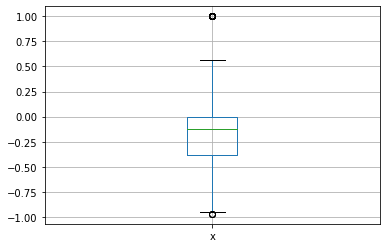

In [3]:
dif_forecast_actuals = df['Weighted_Difference']
bp = pd.DataFrame.boxplot(dif_forecast_actuals, return_type='both')

##### En esta primera prueba vamos a trabajar con todos los datos, sin eliminar los potenciales outliers. Esto podría hacerce en una segunda instancia

## 3. Transformamos de variables

#### 3.1. Redefinición del data frame y encoding de variables categóricas

In [4]:
# Elegimos las variables con las que vamos a trabajar
df1 = df[['Accounting_Forecast','Practice_Descriptor','Project_Probability','Fortnight_To_Bill','Weighted_Difference']]
df = df[['Accounting_Forecast','Practice_Descriptor','Project_Probability','Fortnight_To_Bill','Weighted_Difference']]

# Aplicamos encoding para las variables categóricas nominales
#le = LabelEncoder()
#df1.Accounting_Forecast = df1.Accounting_Forecast.astype('category')# = le.fit_transform(df1.Accounting_Forecast)
df1.Practice_Descriptor = df1.Practice_Descriptor.astype('category')# = le.fit_transform(df1.Practice_Descriptor)
df1.Fortnight_To_Bill = df1.Fortnight_To_Bill.astype(int)#.astype('category')# = le.fit_transform(df1.Fortnight_To_Bill)
df1.Project_Probability = df1.Project_Probability.astype(int)#.astype('category')# = le.fit_transform(df1.Project_Probability)

# Renombramos las varibales originales para mantenerlas en el dataframe y recuperarlas al final de la predicción
df.columns = ['Accounting_Forecast_O', 'Practice_Descriptor_O','Project_Probability_O', 'Fortnight_To_Bill_O','Weighted_Difference']
# Concatenamos los dos data frame por columnas: las primeras variables preservan el formato original, las segundas están listas para modelizar
df1 = pd.concat([df.iloc[:,0:-1],df1],axis=1)
df1

,Accounting_Forecast_O,Practice_Descriptor_O,Project_Probability_O,Fortnight_To_Bill_O,Accounting_Forecast,Practice_Descriptor,Project_Probability,Fortnight_To_Bill,Weighted_Difference
0,2020-02-29,Adaptive Insights,10.0,0,2020-02-29,Adaptive Insights,10,0,1.000000
1,2020-02-29,Adaptive Insights,10.0,1,2020-02-29,Adaptive Insights,10,1,1.000000
2,2020-02-29,IT C&S Argentina,100.0,0,2020-02-29,IT C&S Argentina,100,0,0.006601
3,2020-02-29,IT C&S Argentina,100.0,1,2020-02-29,IT C&S Argentina,100,1,0.000239
4,2020-02-29,IT C&S Argentina,90.0,0,2020-02-29,IT C&S Argentina,90,0,0.006601
...,...,...,...,...,...,...,...,...,...
875,2020-09-30,Workday Integrations,90.0,0,2020-09-30,Workday Integrations,90,0,0.006473
876,2020-09-30,Workday Integrations,90.0,2,2020-09-30,Workday Integrations,90,2,0.131789
877,2020-09-30,Workday Integrations,90.0,4,2020-09-30,Workday Integrations,90,4,0.063067
878,2020-09-30,Workday,100.0,0,2020-09-30,Workday,100,0,-0.010358


#### 3.2. Transformación de variables codificadas por vector embeddings

## 4. Modelo Final

#### 4.1. CatBoost model

In [5]:
# Seleccionamos las variables transformadas
X = df1[['Practice_Descriptor', 'Project_Probability', 'Fortnight_To_Bill']]
y = df1['Weighted_Difference']
# Hacemos el split Train-Test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [19]:
%%time
cat_features_index = [0]

range(3,10,2)

parameters = {"iterations": [100, 125, 150],
              "l2_leaf_reg": np.linspace(0,1,5), 
              "depth" : range(3,10,1), 
              "loss_function": ['Huber:delta=1','Huber:delta=3','Huber:delta=5'],
              "learning_rate" : np.linspace(0.01,0.12,5),
              "early_stopping_rounds" : [1]
             }

#cb = CatBoostRegressor(langevin=True,boost_from_average=True,boosting_type='Plain',silent = True)
cb = CatBoostRegressor(silent = True)
grid_obj = GridSearchCV(estimator=cb, param_grid=parameters, cv = 3)
grid_obj.fit(X_train, y_train, cat_features= cat_features_index)
best_params = grid_obj.best_params_
print(best_params)

{'depth': 5, 'early_stopping_rounds': 1, 'iterations': 125, 'l2_leaf_reg': 0.5, 'learning_rate': 0.065, 'loss_function': 'Huber:delta=3'}
Wall time: 19min 28s


In [20]:
clf = CatBoostRegressor(**best_params,silent = True)
cat_model = clf.fit(X_train,y_train, cat_features= cat_features_index)

##### 4.2.2. Predecimos y evaluamos los resultados

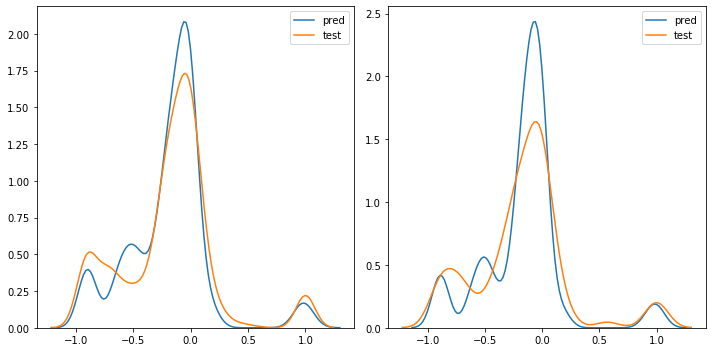

In [21]:
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = cat_model.predict(X_test)
y_train_pred = cat_model.predict(X_train)

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0])
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1])
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [22]:
# Analizamos los resultados principales del modelo
mae_test = np.round(res_df_test['dif_abs'].mean(),2)
gae_test = np.round(res_df_test['dif_abs'].sum(),2)
error_test_rate_abs = np.round(100*gae_test/res_df_test['test'].sum(),2)
error_test = np.round(res_df_test['dif'].sum(),2)
error_test_rate = np.round(100*error_test/res_df_test['test'].sum(),2)
print('El error absoluto medio es: ', mae_test)
print('El error global es: ', error_test)
print('La tasa de error global es: %',error_test_rate)

El error absoluto medio es:  0.12
El error global es:  0.58
La tasa de error global es: % -1.88


In [23]:
# Observamos la importancia de cada feature en la predicción
feature_importances = pd.DataFrame(cat_model.feature_importances_)
feature_importances = pd.concat([feature_importances,pd.DataFrame(X.columns)], axis=1)
feature_importances.columns = ['Importance','Features']
feature_importances = feature_importances.sort_values('Importance',ascending=False).reset_index(drop=True)
feature_importances['Cumulative'] = np.cumsum(feature_importances['Importance'])
feature_importances

,Importance,Features,Cumulative
0,71.212257,Practice_Descriptor,71.212257
1,16.237999,Fortnight_To_Bill,87.450256
2,12.549744,Project_Probability,100.000000


#### 4.2. Light GBM model

In [ ]:
# Elegimos las variables con las que vamos a trabajar
df2 = df1

# Aplicamos encoding para las variables categóricas nominales
le = LabelEncoder()
df2.Accounting_Forecast = le.fit_transform(df2.Accounting_Forecast)
df2.Accounting_Forecast = df2.Accounting_Forecast.astype('category')
df2.Practice_Descriptor = le.fit_transform(df2.Practice_Descriptor)
df2.Practice_Descriptor = df2.Practice_Descriptor.astype('category') 
df2.Fortnight_To_Bill = df2.Fortnight_To_Bill.astype(int)#.astype('category')# = le.fit_transform(df1.Fortnight_To_Bill)
df2.Project_Probability = df2.Project_Probability.astype(int)#.astype('category')# = le.fit_transform(df1.Project_Probability)

# Concatenamos los dos data frame por columnas: las primeras variables preservan el formato original, las segundas están listas para modelizar
df2

In [ ]:
# Seleccionamos las variables transformadas
X = df2[['Practice_Descriptor', 'Project_Probability', 'Fortnight_To_Bill']]
y = df2['Weighted_Difference']
# Hacemos el split Train-Test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [ ]:
%%time
param_dist = {
              "max_depth": range(3,10,2),
              "learning_rate" : np.linspace(0,0.2,4),
              "n_estimators": [50, 100, 150],
              "num_leaves": range(3,10,2),
              "objective" : ['huber'],
              "random_state" : [0],
              "min_child_weight" : range(3,10,2),
              "reg_alpha": np.linspace(0,1.2,4),
              "reg_lambda": np.linspace(0,1.2,4)
             }
#fit_params = {'categorical_features':cat_features_index}
lg = lgb.LGBMRegressor(random_state=0,silent=True)
grid_search = GridSearchCV(lg, param_grid=param_dist, n_jobs=-1, cv = 3)
grid_search.fit(X_train,y_train)
best_params = grid_search.best_params_
print(best_params)

In [ ]:
gbm = lgb.LGBMRegressor(**best_params,silent = True)
gbm_model = gbm.fit(X_train,y_train)

In [ ]:
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = gbm_model.predict(X_test)
y_train_pred = gbm_model.predict(X_train)

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0])
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1])
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [ ]:
# Analizamos los resultados principales del modelo
mae_test = np.round(res_df_test['dif_abs'].mean(),2)
gae_test = np.round(res_df_test['dif_abs'].sum(),2)
error_test_rate_abs = np.round(100*gae_test/res_df_test['test'].sum(),2)
error_test = np.round(res_df_test['dif'].sum(),2)
error_test_rate = np.round(100*error_test/res_df_test['test'].sum(),2)
print('El error absoluto medio es: ', mae_test)
print('El error global es: ', error_test)
print('La tasa de error global es: %',error_test_rate)

In [ ]:
# Observamos la importancia de cada feature en la predicción
feature_importances = pd.DataFrame(gbm_model.feature_importances_)
feature_importances = pd.concat([feature_importances,pd.DataFrame(X.columns)], axis=1)
feature_importances.columns = ['Importance','Features']
feature_importances = feature_importances.sort_values('Importance',ascending=False).reset_index(drop=True)
feature_importances['Cumulative'] = np.cumsum(feature_importances['Importance'])
feature_importances

# No hace falta correr el de LightGBM, solo con el de Catboost está bien

## 5. Proyecciones

In [32]:
# Importamos el dataframe que contiene solo la estimación más representativa para cada proyecto-período (ver dataset_treatment.ipynb)
df_forecast = pd.read_csv(r'\Users\Lucas\BNB_projects\Forecast_alternativo\CatBoost_LightGBM\df_to_predict.csv')
df_forecast

,Accounting_Forecast,Practice_Descriptor,Project_Probability,Fortnight_To_Bill,Amount_Forecast,Amount_Forecast_EUR,ID
0,2020-10-31,IT C&S Argentina,100.0,2,1969061.49,22266.14,IT C&S Argentina-202010
1,2020-10-31,IT C&S Argentina,90.0,2,54856.73,620.32,IT C&S Argentina-202010
2,2020-10-31,JD Edwards,100.0,2,14626.28,165.40,JD Edwards-202010
3,2020-10-31,Oracle Cloud,100.0,2,425.00,425.00,Oracle Cloud-202010
4,2020-10-31,PeopleSoft,100.0,2,84414.52,77040.60,PeopleSoft-202010
...,...,...,...,...,...,...,...
120,2021-03-31,Workday HCM,50.0,10,13500.00,13500.00,Workday HCM-202103
121,2021-03-31,Workday Integrations,10.0,10,800.00,800.00,Workday Integrations-202103
122,2021-03-31,Workday Integrations,100.0,10,36757.17,36757.17,Workday Integrations-202103
123,2021-03-31,Workday Integrations,45.0,10,7563.00,291.89,Workday Integrations-202103


In [33]:
# Elegimos las variables con las que vamos a trabajar
df3 = df_forecast[['Accounting_Forecast','Practice_Descriptor','Project_Probability','Fortnight_To_Bill','Amount_Forecast_EUR']]
df_forecast = df_forecast[['Accounting_Forecast','Practice_Descriptor','Project_Probability','Fortnight_To_Bill','Amount_Forecast_EUR']]

# Aplicamos encoding para las variables categóricas nominales
#le = LabelEncoder()
#df1.Accounting_Forecast = df1.Accounting_Forecast.astype('category')# = le.fit_transform(df1.Accounting_Forecast)
df3.Practice_Descriptor = df3.Practice_Descriptor.astype('category')# = le.fit_transform(df1.Practice_Descriptor)
df3.Fortnight_To_Bill = df3.Fortnight_To_Bill.astype(int)#.astype('category')# = le.fit_transform(df1.Fortnight_To_Bill)
df3.Project_Probability = df3.Project_Probability.astype(int)#.astype('category')# = le.fit_transform(df1.Project_Probability)

# Renombramos las varibales originales para mantenerlas en el dataframe y recuperarlas al final de la predicción
df_forecast.columns = ['Accounting_Forecast_O', 'Practice_Descriptor_O','Project_Probability_O', 'Fortnight_To_Bill_O','Amount_Forecast_EUR']
# Concatenamos los dos data frame por columnas: las primeras variables preservan el formato original, las segundas están listas para modelizar
df3 = pd.concat([df_forecast.iloc[:,0:-1],df3],axis=1)
df3

,Accounting_Forecast_O,Practice_Descriptor_O,Project_Probability_O,Fortnight_To_Bill_O,Accounting_Forecast,Practice_Descriptor,Project_Probability,Fortnight_To_Bill,Amount_Forecast_EUR
0,2020-10-31,IT C&S Argentina,100.0,2,2020-10-31,IT C&S Argentina,100,2,22266.14
1,2020-10-31,IT C&S Argentina,90.0,2,2020-10-31,IT C&S Argentina,90,2,620.32
2,2020-10-31,JD Edwards,100.0,2,2020-10-31,JD Edwards,100,2,165.40
3,2020-10-31,Oracle Cloud,100.0,2,2020-10-31,Oracle Cloud,100,2,425.00
4,2020-10-31,PeopleSoft,100.0,2,2020-10-31,PeopleSoft,100,2,77040.60
...,...,...,...,...,...,...,...,...,...
120,2021-03-31,Workday HCM,50.0,10,2021-03-31,Workday HCM,50,10,13500.00
121,2021-03-31,Workday Integrations,10.0,10,2021-03-31,Workday Integrations,10,10,800.00
122,2021-03-31,Workday Integrations,100.0,10,2021-03-31,Workday Integrations,100,10,36757.17
123,2021-03-31,Workday Integrations,45.0,10,2021-03-31,Workday Integrations,45,10,291.89


In [34]:
# Hacemos las predicciones y definimos nuestro data frame final con predicciones en la última columna
X = df3[['Practice_Descriptor', 'Fortnight_To_Bill', 'Project_Probability']]
predictions = cat_model.predict(X)

df_forecast['Predicted_Weights'] = np.round(predictions,2)
cols_selected = ['Accounting_Forecast_O', 'Practice_Descriptor_O','Project_Probability_O', 'Fortnight_To_Bill_O',
                 'Amount_Forecast_EUR','Predicted_Weights']
df_predictions_final = df_forecast[cols_selected]

df_predictions_final

,Accounting_Forecast_O,Practice_Descriptor_O,Project_Probability_O,Fortnight_To_Bill_O,Amount_Forecast_EUR,Predicted_Weights
0,2020-10-31,IT C&S Argentina,100.0,2,22266.14,-0.04
1,2020-10-31,IT C&S Argentina,90.0,2,620.32,-0.05
2,2020-10-31,JD Edwards,100.0,2,165.40,-0.90
3,2020-10-31,Oracle Cloud,100.0,2,425.00,-0.07
4,2020-10-31,PeopleSoft,100.0,2,77040.60,0.02
...,...,...,...,...,...,...
120,2021-03-31,Workday HCM,50.0,10,13500.00,-0.04
121,2021-03-31,Workday Integrations,10.0,10,800.00,-0.03
122,2021-03-31,Workday Integrations,100.0,10,36757.17,-0.07
123,2021-03-31,Workday Integrations,45.0,10,291.89,-0.01


### $Amount_{Actuals} = Amount_{Forecast}\frac{(1-WD)}{(1+WD)}$

In [35]:
wd = df_predictions_final['Predicted_Weights']
df_predictions_final['Amount_Actual_Predicted'] = df_predictions_final['Amount_Forecast_EUR']*((1-wd)/(1+wd))

In [36]:
df_predictions_final.to_excel('predictions20201026.xlsx', engine='xlsxwriter')
df_predictions_final

,Accounting_Forecast_O,Practice_Descriptor_O,Project_Probability_O,Fortnight_To_Bill_O,Amount_Forecast_EUR,Predicted_Weights,Amount_Actual_Predicted
0,2020-10-31,IT C&S Argentina,100.0,2,22266.14,-0.04,24121.651667
1,2020-10-31,IT C&S Argentina,90.0,2,620.32,-0.05,685.616842
2,2020-10-31,JD Edwards,100.0,2,165.40,-0.90,3142.600000
3,2020-10-31,Oracle Cloud,100.0,2,425.00,-0.07,488.978495
4,2020-10-31,PeopleSoft,100.0,2,77040.60,0.02,74019.400000
...,...,...,...,...,...,...,...
120,2021-03-31,Workday HCM,50.0,10,13500.00,-0.04,14625.000000
121,2021-03-31,Workday Integrations,10.0,10,800.00,-0.03,849.484536
122,2021-03-31,Workday Integrations,100.0,10,36757.17,-0.07,42290.507419
123,2021-03-31,Workday Integrations,45.0,10,291.89,-0.01,297.786768


In [37]:
df_predictions_final.groupby(['Accounting_Forecast_O'], as_index=False).agg({'Amount_Forecast_EUR':'sum'})

,Accounting_Forecast_O,Amount_Forecast_EUR
0,2020-10-31,464244.85
1,2020-11-30,505653.28
2,2020-12-31,463095.46
3,2021-01-31,460931.13
4,2021-02-28,371602.03
5,2021-03-31,310194.93


In [38]:
df_predictions_final.groupby(['Accounting_Forecast_O'], as_index=False).agg({'Amount_Actual_Predicted':'sum'})

,Accounting_Forecast_O,Amount_Actual_Predicted
0,2020-10-31,466534.569237
1,2020-11-30,517853.496864
2,2020-12-31,526444.487097
3,2021-01-31,576519.377529
4,2021-02-28,457632.644071
5,2021-03-31,384137.639626


In [39]:
# Guardamos el dataframe final con predicciones
df_predictions_final.to_csv("df_predictions_completo20200831.csv", sep='\t',index=False)